# Learning Simple Graph in Langchain

LangGraph allows you to create stateful, multi-step applications by defining workflows as graphs. Each node in the graph represents a computation step (often a function or a LangChain Runnable), and edges define the flow of control and data between these nodes. The state is passed along the edges and can be updated by each node.

Our Simple Example:

We'll create a graph that:

Takes a topic as input.
- Generates a short introductory sentence about the topic.
- Generates a concluding sentence about the topic.
- Combines the introduction and conclusion.

Core Concepts Illustrated:

- State: The data that flows through the graph (topic, intro, conclusion, final text).
- Nodes: Functions that perform specific tasks (generate_intro, generate_conclusion, combine_text).
- Edges: Define the sequence of execution (Intro -> Conclusion -> Combine).
- Graph: The overall workflow definition.

In [4]:
!python --version

Python 3.12.9


In [1]:
%pip install --quiet -U langgraph

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os

from typing import TypedDict, Annotated, Sequence, Dict, Any
from langgraph.graph import StateGraph, END


In [7]:
import os
from typing import TypedDict, Annotated, Sequence, Dict, Any, Optional
from langgraph.graph import StateGraph, END

# --- 1. Define the State ---
# The state is the data structure that flows through the graph.
# We use TypedDict for clarity and type safety.

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        topic: The input topic for generation.
        introduction: The generated introductory sentence.
        conclusion: The generated concluding sentence.
        final_text: The combined introduction and conclusion.
    """
    topic: str
    introduction: Optional[str]  # Use Optional[str] to indicate it might not be set initially
    conclusion: Optional[str]
    final_text: Optional[str]


In [8]:
# --- 2. Define the Nodes ---
# Nodes are functions that perform actions and modify the state.
# They take the current state as input and return a dictionary
# containing the *updates* to the state.

def generate_intro(state: GraphState) -> Dict[str, Any]:
    """Generates an introductory sentence based on the topic."""
    print("--- Node: Generating Introduction ---")
    topic = state['topic']
    # In a real app, you might use an LLM here.
    intro_text = f"Let's talk about {topic}."
    print(f"    Generated: {intro_text}")
    return {"introduction": intro_text} # Return the state update

def generate_conclusion(state: GraphState) -> Dict[str, Any]:
    """Generates a concluding sentence based on the topic."""
    print("--- Node: Generating Conclusion ---")
    topic = state['topic']
    # In a real app, you might use an LLM here.
    concl_text = f"In summary, {topic} is an interesting subject."
    print(f"    Generated: {concl_text}")
    return {"conclusion": concl_text} # Return the state update

def combine_text(state: GraphState) -> Dict[str, Any]:
    """Combines the introduction and conclusion."""
    print("--- Node: Combining Text ---")
    intro = state.get('introduction', '') # Safely get values
    concl = state.get('conclusion', '')
    combined = f"{intro}\n{concl}"
    print(f"    Combined:\n{combined}")
    return {"final_text": combined} # Return the state update

In [9]:
# --- 3. Define the Graph ---
# Instantiate StateGraph with the state definition.

workflow = StateGraph(GraphState)

# Add nodes to the graph. Give each node a unique name.
workflow.add_node("intro_node", generate_intro)
workflow.add_node("conclusion_node", generate_conclusion)
workflow.add_node("combine_node", combine_text)

# --- 4. Define the Edges ---
# Edges define the flow of control.

# Set the entry point - the first node to execute.
workflow.set_entry_point("intro_node")

# Connect nodes sequentially.
workflow.add_edge("intro_node", "conclusion_node")
workflow.add_edge("conclusion_node", "combine_node")

# Define the end point. The special 'END' marker signifies the graph finishes
# after this node.
workflow.add_edge("combine_node", END)


In [10]:
# --- 5. Compile the Graph ---
# Compile the graph into a runnable application.

app = workflow.compile()


# --- 6. Run the Graph ---
# Invoke the compiled graph with initial input.
# The input should match the structure needed by the entry node(s).

initial_input = {"topic": "LangGraph Basics"}
print(f"\n--- Running Graph with input: {initial_input} ---")

# 'invoke' runs the graph until it reaches the END state
final_state = app.invoke(initial_input)

print("\n--- Graph Execution Finished ---")
print("\n--- Final State ---")
# Pretty print the final state dictionary
import json
print(json.dumps(final_state, indent=2))

print("\n--- Final Combined Text ---")
print(final_state.get("final_text")) # Access the final output from the state.


--- Running Graph with input: {'topic': 'LangGraph Basics'} ---
--- Node: Generating Introduction ---
    Generated: Let's talk about LangGraph Basics.
--- Node: Generating Conclusion ---
    Generated: In summary, LangGraph Basics is an interesting subject.
--- Node: Combining Text ---
    Combined:
Let's talk about LangGraph Basics.
In summary, LangGraph Basics is an interesting subject.

--- Graph Execution Finished ---

--- Final State ---
{
  "topic": "LangGraph Basics",
  "introduction": "Let's talk about LangGraph Basics.",
  "conclusion": "In summary, LangGraph Basics is an interesting subject.",
  "final_text": "Let's talk about LangGraph Basics.\nIn summary, LangGraph Basics is an interesting subject."
}

--- Final Combined Text ---
Let's talk about LangGraph Basics.
In summary, LangGraph Basics is an interesting subject.


1 - Define the State (GraphState): We use TypedDict to define the structure of data that will be passed between nodes. This makes it clear what keys (topic, introduction, etc.) are expected at different stages. Initially, introduction, conclusion, and final_text can be None.

2 - Define the Nodes (generate_intro, generate_conclusion, combine_text):

Each node is a Python function that accepts the current state dictionary as its argument.

Inside the function, it performs its task (here, generating simple strings, but could involve LLM calls, API requests, etc.).

Crucially, each node returns a dictionary containing only the changes or updates it wants to make to the state. 

LangGraph automatically merges these updates into the main state before passing it to the next node. For example, generate_intro returns {"introduction": intro_text}.


3 - Define the Graph (workflow = StateGraph(GraphState)): We create an instance of StateGraph, telling it to use our GraphState definition to manage the data flow.

4 - Add Nodes (workflow.add_node(...)): We register our node functions with the graph, giving each a unique string name ("intro_node", "conclusion_node", "combine_node"). This name is used when defining edges.

5 - Define the Edges (workflow.set_entry_point(...), workflow.add_edge(...)):

set_entry_point("intro_node"): This tells LangGraph where to start the execution. The input provided to app.invoke() will be passed to this node first.

add_edge("intro_node", "conclusion_node"): This creates a directed link. After intro_node finishes, control passes to conclusion_node. The updated state (including the introduction) is passed along.

add_edge("conclusion_node", "combine_node"): Similarly, connects the conclusion generator to the combiner.

add_edge("combine_node", END): This connects the final node combine_node to the special END marker. When the graph reaches END, execution stops, and the final state is returned.

6 - Compile the Graph (app = workflow.compile()): This step takes the graph definition (nodes and edges) and creates an executable LangChain Runnable object (app). This object knows how to traverse the graph based on the defined structure.

7 - Run the Graph (final_state = app.invoke(initial_input)):

We call the invoke() method on the compiled app.

We provide the initial input as a dictionary ({"topic": "LangGraph Basics"}). This dictionary populates the initial state.

LangGraph executes the nodes in the defined order (intro_node -> conclusion_node -> combine_node), updating the state at each step.

When the END state is reached, invoke() returns the complete final state dictionary.

We then print the final_state and extract the desired output (final_text).

This example demonstrates the fundamental workflow of defining state, nodes, edges, compiling, and running a simple sequential graph in LangGraph. You can build much more complex graphs with conditional edges (deciding which node to go to next based on the state), cycles, and integration with various LangChain components.

# Lets visualize it;

It will open a window showing a simple diagram of your LangGraph workflow. 

You'll see the nodes as circles labeled with their names, and arrows indicating the flow of execution from intro_node to conclusion_node, then to combine_node, and finally to END. 

This provides a clear visual representation of the sequential structure of your graph.

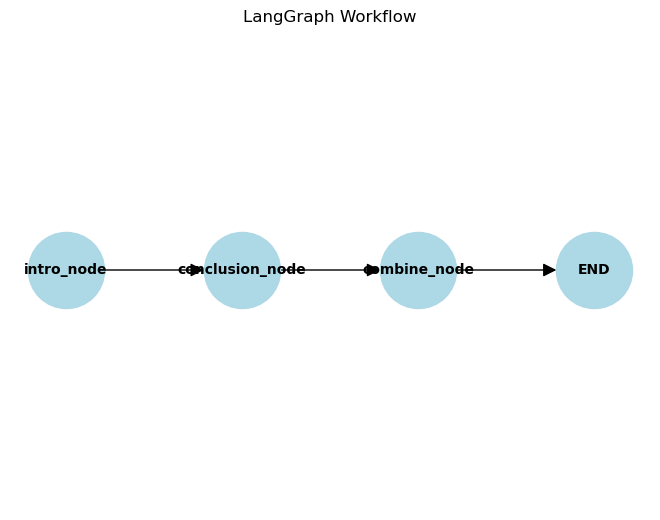

In [11]:
import networkx as nx
import matplotlib.pyplot as plt

# Define the nodes
nodes = ["intro_node", "conclusion_node", "combine_node", "END"]

# Define the edges
edges = [
    ("intro_node", "conclusion_node"),
    ("conclusion_node", "combine_node"),
    ("combine_node", "END"),
]

# Create a directed graph
graph = nx.DiGraph()
graph.add_nodes_from(nodes)
graph.add_edges_from(edges)

# Define positions for the nodes (for better layout)
pos = {
    "intro_node": (0, 1),
    "conclusion_node": (1, 1),
    "combine_node": (2, 1),
    "END": (3, 1),
}

# Draw the graph
nx.draw(
    graph,
    pos,
    with_labels=True,
    node_size=3000,
    node_color="lightblue",
    font_size=10,
    font_weight="bold",
    arrowsize=20,
)

# Add a title
plt.title("LangGraph Workflow")

# Show the plot
plt.show()

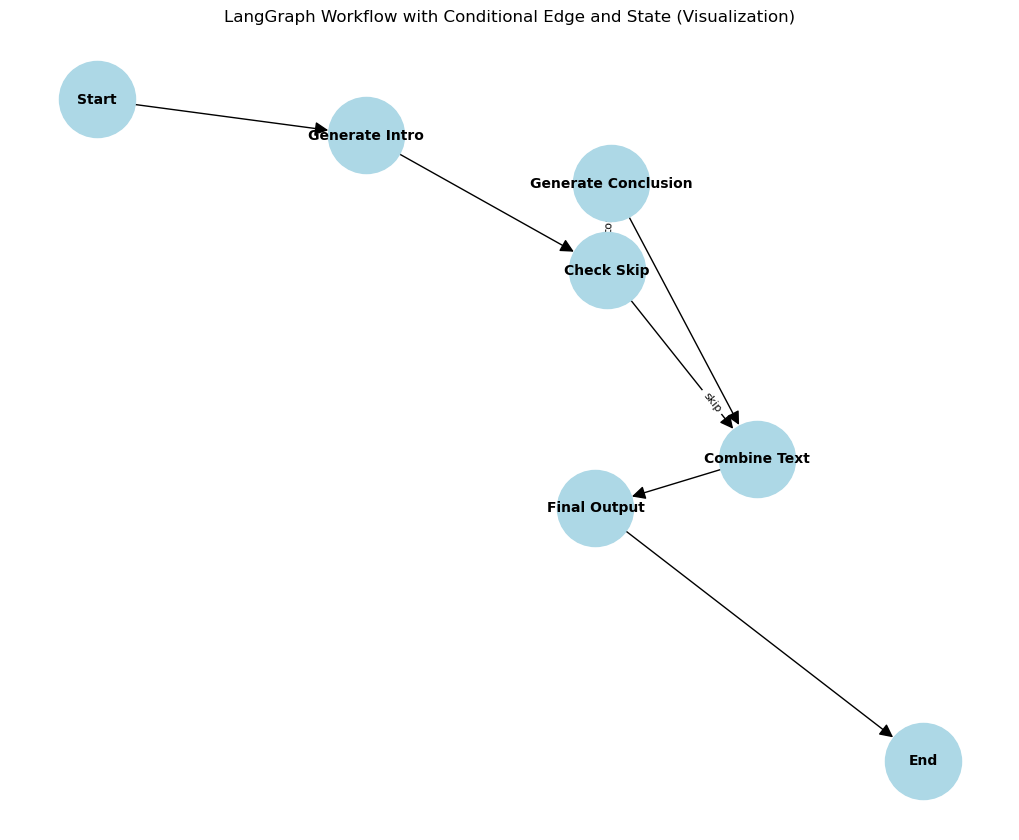


--- Simulating Graph Run ---
Initial State:
Topic: A very long and interesting topic
Intro: None
Conclusion: None
Final: None
Skip Conclusion: False

--- Node: Generating Introduction ---
    Generated: Let's begin discussing A very long and interesting topic.

State after intro_node:
Topic: A very long and interesting topic
Intro: Let's begin discussing A very long and interesting topic.
Conclusion: None
Final: None
Skip Conclusion: False

--- Node: Checking Skip Condition ---
    Topic is long enough, proceeding with conclusion.

Skip Decision: continue

--- Node: Generating Conclusion ---
    Generated: In conclusion, A very long and interesting topic is quite noteworthy.

State after conclusion_node:
Topic: A very long and interesting topic
Intro: Let's begin discussing A very long and interesting topic.
Conclusion: In conclusion, A very long and interesting topic is quite noteworthy.
Final: None
Skip Conclusion: False

--- Node: Combining Text ---
    Combined:
Let's begin discus

In [12]:
import networkx as nx
import matplotlib.pyplot as plt

# --- 1. Define the Graph State (for visualization purposes) ---
class GraphState:
    def __init__(self, topic=None, introduction=None, conclusion=None, final_text=None, should_skip_conclusion=False):
        self.topic = topic
        self.introduction = introduction
        self.conclusion = conclusion
        self.final_text = final_text
        self.should_skip_conclusion = should_skip_conclusion

    def __str__(self):
        return f"Topic: {self.topic}\nIntro: {self.introduction}\nConclusion: {self.conclusion}\nFinal: {self.final_text}\nSkip Conclusion: {self.should_skip_conclusion}"

# --- 2. Define Dummy Nodes (representing the logic) ---
def generate_intro(state: GraphState) -> GraphState:
    print("--- Node: Generating Introduction ---")
    state.introduction = f"Let's begin discussing {state.topic}."
    print(f"    Generated: {state.introduction}")
    return state

def check_skip_condition(state: GraphState) -> str:
    print("--- Node: Checking Skip Condition ---")
    if len(state.topic) < 10:
        state.should_skip_conclusion = True
        print("    Topic is short, skipping conclusion.")
        return "skip"
    else:
        state.should_skip_conclusion = False
        print("    Topic is long enough, proceeding with conclusion.")
        return "continue"

def generate_conclusion(state: GraphState) -> GraphState:
    print("--- Node: Generating Conclusion ---")
    if not state.should_skip_conclusion:
        state.conclusion = f"In conclusion, {state.topic} is quite noteworthy."
        print(f"    Generated: {state.conclusion}")
    else:
        print("    Conclusion was skipped.")
    return state

def combine_text(state: GraphState) -> GraphState:
    print("--- Node: Combining Text ---")
    state.final_text = f"{state.introduction}\n{state.conclusion if state.conclusion else ''}"
    print(f"    Combined:\n{state.final_text}")
    return state

def final_output(state: GraphState):
    print("--- Node: Final Output ---")
    print(f"    Final Text:\n{state.final_text}")
    return state

# --- 3. Define the Graph Structure for Visualization ---
graph = nx.DiGraph()

# Add Nodes (representing the LangGraph nodes)
graph.add_node("start", label="Start", shape="ellipse")
graph.add_node("intro_node", label="Generate Intro", shape="box")
graph.add_node("check_skip", label="Check Skip", shape="diamond")
graph.add_node("conclusion_node", label="Generate Conclusion", shape="box")
graph.add_node("combine_node", label="Combine Text", shape="box")
graph.add_node("output_node", label="Final Output", shape="box")
graph.add_node("end", label="End", shape="double_circle")

# Add Edges (representing the flow)
graph.add_edge("start", "intro_node")
graph.add_edge("intro_node", "check_skip")

# Conditional Edges
graph.add_edge("check_skip", "conclusion_node", label="continue")
graph.add_edge("check_skip", "combine_node", label="skip") # If skipping conclusion

graph.add_edge("conclusion_node", "combine_node")
graph.add_edge("combine_node", "output_node")
graph.add_edge("output_node", "end")

# --- 4. Visualize the Graph ---
pos = nx.spring_layout(graph, seed=42)  # You can try other layouts like 'planar' or 'dot'

node_labels = nx.get_node_attributes(graph, 'label')
edge_labels = nx.get_edge_attributes(graph, 'label')

plt.figure(figsize=(10, 8))
nx.draw(graph, pos, with_labels=True, labels=node_labels, node_size=3000, node_color="lightblue", font_size=10, font_weight="bold", arrowsize=20)
nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, font_size=8, label_pos=0.3) # Adjust label_pos for better placement

plt.title("LangGraph Workflow with Conditional Edge and State (Visualization)")
plt.show()

# --- 5. Simulate a Run (to see the state flow conceptually) ---
print("\n--- Simulating Graph Run ---")
initial_state = GraphState(topic="A very long and interesting topic")
print(f"Initial State:\n{initial_state}\n")

state_after_intro = generate_intro(initial_state)
print(f"\nState after intro_node:\n{state_after_intro}\n")

skip_decision = check_skip_condition(state_after_intro)
print(f"\nSkip Decision: {skip_decision}\n")

state_after_conclusion = generate_conclusion(state_after_intro)
print(f"\nState after conclusion_node:\n{state_after_conclusion}\n")

final_state = combine_text(state_after_conclusion)
print(f"\nFinal State after combine_node:\n{final_state}\n")

final_output(final_state)

Explanation of Changes and How it Visualizes the Concepts:


GraphState Class (for Visualization):


We create a simple Python class GraphState to represent the data that flows through the graph. This is a simplified version of your TypedDict for easier manipulation in the visualization.

It includes attributes like topic, introduction, conclusion, final_text, and a new attribute should_skip_conclusion to demonstrate a conditional path.

The __str__ method is added for easy printing of the state.
Dummy Nodes (Functions):


The generate_intro, check_skip_condition, generate_conclusion, combine_text, and final_output functions now take and return instances of our GraphState class.

The check_skip_condition node introduces the conditional logic: it decides whether to skip the conclusion_node based on the length of the topic and updates the should_skip_conclusion attribute in the GraphState.

Graph Structure for Visualization (networkx):

We create a networkx.DiGraph() as before.

Nodes: We add nodes representing each step in the workflow, including a start and end node for better visual flow. We also add a check_skip node to explicitly represent the conditional check.

Edges:

We add standard sequential edges.

Conditional Edges: The key change is how we represent the conditional flow from the check_skip node. We add two edges originating from check_skip:

One going to conclusion_node with the label "continue".

Another going directly to combine_node with the label "skip".

The labels on these edges visually indicate the condition that determines which path is taken.

Visualization:

We use nx.spring_layout (or you can experiment with other layouts) to position the nodes.
nx.draw is used to draw the nodes and edges.

nx.draw_networkx_edge_labels is crucial here. It allows us to display the labels we assigned to the conditional edges ("continue" and "skip"), making the conditional flow visually clear.

Node shapes are added for better distinction (ellipse for start/end, box for processing, diamond for decision).

Simulate a Run:


We include a section to simulate the execution of the (conceptual) LangGraph. We create an initial GraphState, pass it through the dummy nodes, and print the state at each step. This helps you understand how the GraphState might evolve as it moves through the graph and how the conditional logic in check_skip_condition would influence the flow.


How this visualization represents the concepts:


- Nodes: Each node in the networkx graph corresponds to a processing step or a decision point in your LangGraph.
- Edges: The directed edges show the possible flow of the GraphState from one node to the next.
- Graph State: While the visualization itself doesn't show the data within the GraphState, the simulation part demonstrates how the GraphState is passed between nodes and how its attributes are modified.
- Conditional Edges: The two edges originating from the check_skip node, with their respective labels ("continue" and "skip"), clearly illustrate the conditional branching in the workflow. The check_skip node acts as a router, deciding which path the process will take based on the state.

When you run this code, you'll see a visual representation of your LangGraph workflow, including the conditional path, making the structure and flow much easier to understand. The simulation further clarifies how the GraphState is involved.